In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPooling2D, Conv2D
from keras import regularizers, activations
import matplotlib.pyplot as plt
from sklearn.metrics import label_ranking_average_precision_score, multilabel_confusion_matrix
import math
from tensorflow.keras import regularizers

### Load the Sentence Encoder model (pretrained). It will be used for obtaining embeddings for text.

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


Dictionaries to easily go from genre name to corresponding label index and vice-versa

In [ ]:
genreToIndex = {
    "Drama": 0,
    "Comedy": 1,
    "Thriller": 2,
    "Action": 3,
    "Romance": 4,
    "Adventure": 5,
    "Crime": 6,
    "Science Fiction": 7,
    "Horror": 8,
    "Family": 9,
    "Fantasy": 10,
    "Mystery": 11,
    "Animation": 12,
    "History": 13,
    "Music": 14,
    "War": 15,
    "Documentary": 16,
    "Western": 17,
    "Foreign": 18,
    "TV Movie": 19
}

indexToGenre = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "Adventure",
    "Crime",
    "Science Fiction",
    "Horror",
    "Family",
    "Fantasy",
    "Mystery",
    "Animation",
    "History",
    "Music",
    "War",
    "Documentary",
    "Western",
    "Foreign",
    "TV Movie"
]

### Load the dataset into a dataframe

In [ ]:
csv_path = '/content/drive/MyDrive/EDA/Project/data/tmdb.csv'

In [ ]:
df = pd.read_csv(csv_path)
df.head(3)

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


### Helper functions for processing the data

Transform the genre column (each element is a list of genres) into a column where each element is a list of labels with binary values: 1 if the movie is associated with the genre at that index and 0 otherwise.

In [ ]:
def one_hot_encode_genres(df):
  labels = []
  for genres in df["genres"]:
    genreList = json.loads(genres)
    label = [0 for _ in range(len(indexToGenre))]
    for genre in genreList:
      genreName = genre["name"]
      genreIndex = genreToIndex[genreName]
      label[genreIndex] = 1
    labels.append(label)
  return labels

Extract the overview column (as a list) and replace NaN values with the empty string.

In [ ]:
def get_overviews(df):
  overviews = df["overview"].fillna("")
  return list(overviews)

Extract the title column (as a list) and replace NaN values with the empty string

In [ ]:
def get_titles(df):
  titles = df["title"].fillna("")
  return list(titles)

Extract the tagline column (as a list) and replace NaN values with the empty string

In [ ]:
def get_taglines(df):
  taglines = df["tagline"].fillna("")
  return list(taglines)

Extract the keywords column (as a list) and concatenate all keywords (separated by whitespace) for each example separately.

In [ ]:
def get_keywords_concat(df):
  keywordsAll = []
  for keywordsJson in df["keywords"]:
    keywordsList = json.loads(keywordsJson)
    keywords = []
    for keyword in keywordsList:
      keywordName = keyword["name"]
      keywords.append(keywordName)
    keywordsAll.append(" ".join(keywords))
  return keywordsAll

Build a dataframe from a list of lists (future columns) and a list of names (future column names).

In [ ]:
def get_dataframe(data_list, column_list):
  assert len(data_list) == len(column_list)

  newDf = pd.DataFrame()
  for i in range(len(data_list)):
    column = column_list[i]
    data = data_list[i]
    newDf[column] = data
    
  return newDf

Extract all four text columns (as numpy arrays) and feed them to the Sentence Encoder in order to get their embeddings.

In [ ]:
overviews = get_overviews(df)
taglines = get_taglines(df)
titles = get_titles(df)
keywords = get_keywords_concat(df)


In [ ]:
overviews_enc = np.array(encoder(overviews))
taglines_enc = np.array(encoder(taglines))
titles_enc = np.array(encoder(titles))
keywords_enc = np.array(encoder(keywords))
print(overviews_enc.shape)
print(taglines_enc.shape)
print(titles_enc.shape)
print(keywords_enc.shape)

(4775, 512)
(4775, 512)
(4775, 512)
(4775, 512)


Concatenate all four embeddings along the channels axis (to take advantage of the CNN approach). The output has shape (512, 4).

In [ ]:
def concat_features_cnn(features):
  features_with_channel = [np.reshape(feature, newshape=(feature.shape[0], -1, 1)) for feature in features]
  return np.concatenate(features_with_channel, axis=-1)

In [ ]:
features = concat_features_cnn(
    [
     overviews_enc,
     taglines_enc,
     titles_enc,
     keywords_enc
    ]
)
print(features.shape)

(4775, 512, 4)


In [ ]:
labels = np.array(one_hot_encode_genres(df))
print(labels.shape)

(4775, 20)


Divide the data into a train and a test set.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=6)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(3820, 512, 4)
(955, 512, 4)
(3820, 20)
(955, 20)


### Convolutional Neural Network

Define the CNN architecture.

In [ ]:
def create_cnn(n_genres=20):
  cnn = Sequential([
      Conv1D(filters=32, kernel_size=4, strides=2, padding='valid', kernel_regularizer=regularizers.l2(0.0001)),
      BatchNormalization(),
      Activation('relu'),

      Conv1D(filters=64, kernel_size=4, strides=2, padding='valid', kernel_regularizer=regularizers.l2(0.0001)),
      BatchNormalization(),
      Activation('relu'),

      Conv1D(filters=128, kernel_size=4, strides=2, padding='valid', kernel_regularizer=regularizers.l2(0.0001)),
      BatchNormalization(),
      Activation('relu'),

      Flatten(),

      Dense(64, kernel_regularizer=regularizers.l2(0.00001)),
      BatchNormalization(),
      Activation('relu'),
      Dropout(0.5),

      Dense(64, kernel_regularizer=regularizers.l2(0.00001)),
      BatchNormalization(),
      Activation('relu'),
      Dropout(0.5),

      Dense(n_genres),
      Activation('sigmoid')
  ])
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  cnn.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())
  return cnn

In [ ]:
def train_cnn(cnn, epochs, train_features, train_labels, val_features, val_labels):
  history = cnn.fit(x=train_features, y=train_labels, batch_size=64, epochs=epochs, validation_data=(val_features, val_labels), verbose=2, shuffle=True)
  return history

In [ ]:
cnn = create_cnn()

Train the CNN.

In [ ]:
history = train_cnn(cnn, 25, train_features, train_labels, test_features, test_labels)

Epoch 1/25
60/60 - 3s - loss: 0.5990 - val_loss: 0.5963 - 3s/epoch - 55ms/step
Epoch 2/25
60/60 - 1s - loss: 0.3817 - val_loss: 0.4803 - 836ms/epoch - 14ms/step
Epoch 3/25
60/60 - 1s - loss: 0.3160 - val_loss: 0.4134 - 813ms/epoch - 14ms/step
Epoch 4/25
60/60 - 1s - loss: 0.2864 - val_loss: 0.3701 - 809ms/epoch - 13ms/step
Epoch 5/25
60/60 - 1s - loss: 0.2651 - val_loss: 0.3488 - 819ms/epoch - 14ms/step
Epoch 6/25
60/60 - 1s - loss: 0.2532 - val_loss: 0.3249 - 891ms/epoch - 15ms/step
Epoch 7/25
60/60 - 1s - loss: 0.2417 - val_loss: 0.3031 - 827ms/epoch - 14ms/step
Epoch 8/25
60/60 - 1s - loss: 0.2304 - val_loss: 0.2774 - 816ms/epoch - 14ms/step
Epoch 9/25
60/60 - 1s - loss: 0.2252 - val_loss: 0.2495 - 811ms/epoch - 14ms/step
Epoch 10/25
60/60 - 1s - loss: 0.2146 - val_loss: 0.2370 - 894ms/epoch - 15ms/step
Epoch 11/25
60/60 - 1s - loss: 0.2101 - val_loss: 0.2300 - 822ms/epoch - 14ms/step
Epoch 12/25
60/60 - 1s - loss: 0.2030 - val_loss: 0.2285 - 811ms/epoch - 14ms/step
Epoch 13/25
60/6

Plot loss evolution.

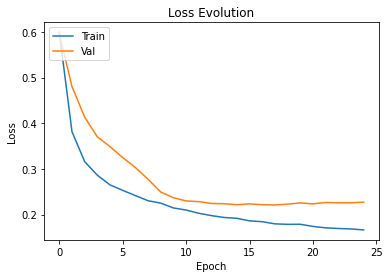

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


### Check performance

Predict on test data.

In [ ]:
test_preds = cnn.predict(test_features)

Check LRAP of the model, for test data.

In [ ]:
print(label_ranking_average_precision_score(y_true=test_labels, y_score=test_preds))

0.789515229536363


In [ ]:
test_preds_rounded = np.rint(test_preds)
test_preds_rounded = test_preds_rounded.astype('i')
for i in range(5):
  print(test_labels[i])
  print(test_preds_rounded[i])
  print()

[1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



### Visualize how well the model performs

Display the confusion graph for each genre.

In [ ]:
def show_confusion_graph(y_true, y_pred):
  cols = 4
  conf_mat = multilabel_confusion_matrix(y_true, y_pred)
  genres_count = len(indexToGenre)
  figures_count = int(math.ceil(genres_count / cols))
  for figure_idx in range(figures_count):
    fig, axs = plt.subplots(1, cols, figsize=(16, 3))
    genre_idx = figure_idx * cols
    offset = 0
    while offset < cols and genre_idx + offset < genres_count:
      col = offset
      mat = conf_mat[genre_idx + offset]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      names = ["TP", "FP", "FN", "TN"]
      values = [tp, fp, fn, tn]
      axs[col].bar(names, values)
      axs[col].set_title(indexToGenre[genre_idx + offset])
      offset += 1
    plt.show()

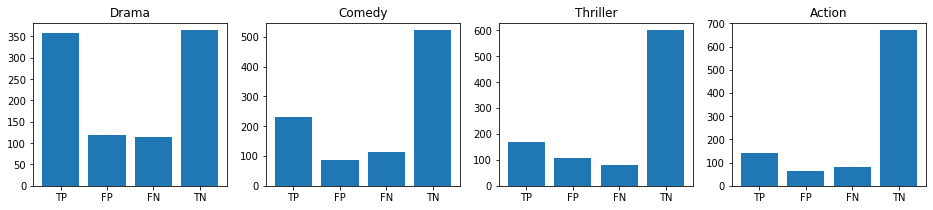

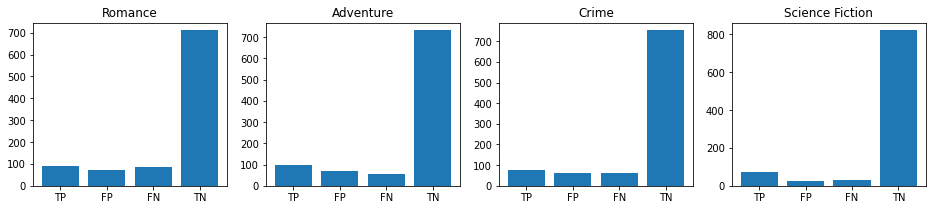

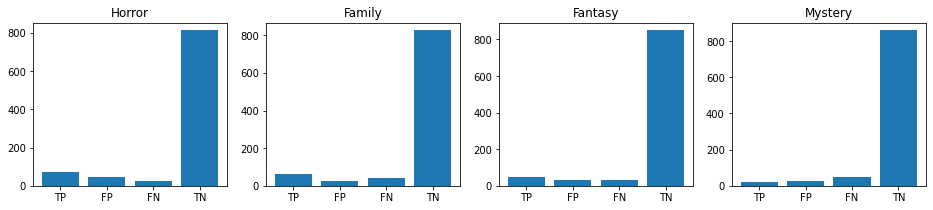

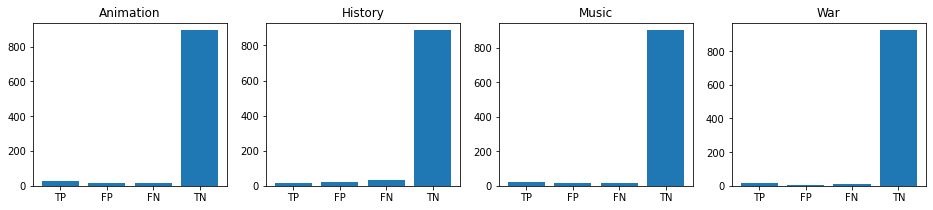

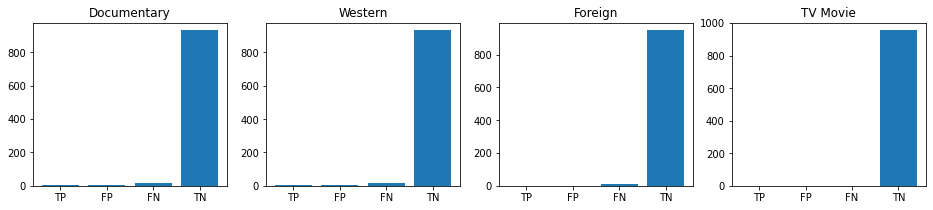

In [ ]:
show_confusion_graph(test_labels, test_preds_rounded)

Display the confusion matrix for each genre.

In [ ]:
def show_confusion_matrix(y_true, y_pred):
    print("Confusion Matrix for each genre")
    print("Format: ")
    print(np.array([["True Positives", "False Positives"],
                    ["False Negatives", "True Negatives"]]))
    conf_mat = multilabel_confusion_matrix(y_true, y_pred)
    for i in range(len(indexToGenre)):
      genre = indexToGenre[i]
      mat = conf_mat[i]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      print()
      print(genre)
      print(np.array([[tp, fp], [fn, tn]]))


In [ ]:
show_confusion_matrix(test_labels, test_preds_rounded)

Confusion Matrix for each genre
Format: 
[['True Positives' 'False Positives']
 ['False Negatives' 'True Negatives']]

Drama
[[358 119]
 [114 364]]

Comedy
[[231  88]
 [115 521]]

Thriller
[[169 108]
 [ 79 599]]

Action
[[141  65]
 [ 80 669]]

Romance
[[ 89  72]
 [ 84 710]]

Adventure
[[ 99  69]
 [ 55 732]]

Crime
[[ 77  63]
 [ 63 752]]

Science Fiction
[[ 75  28]
 [ 31 821]]

Horror
[[ 72  46]
 [ 24 813]]

Family
[[ 62  26]
 [ 41 826]]

Fantasy
[[ 47  29]
 [ 30 849]]

Mystery
[[ 20  29]
 [ 47 859]]

Animation
[[ 28  17]
 [ 18 892]]

History
[[ 18  20]
 [ 32 885]]

Music
[[ 22  18]
 [ 15 900]]

War
[[ 19   5]
 [  8 923]]

Documentary
[[  4   3]
 [ 18 930]]

Western
[[  3   2]
 [ 19 931]]

Foreign
[[  0   0]
 [  8 947]]

TV Movie
[[  0   0]
 [  1 954]]
